# 2自由度制御

以下のシステムを想定します。

<img src='two_degrees_of_freedom_control_with_d_bd.drawio.svg'>

入力$r$、$d$と出力$y$の関係は以下のようになります。

\begin{eqnarray}
u_{ff} &=& \frac{F(s)}{P(s)} r \\
u_{fb} &=& K(s)( F(s)r - y ) \\
y &=& P(s)( u_{ff} + u_{fb} + d ) \\
  &=& F(s) r + \frac{P(s)}{1+K(s)P(s)}d
\end{eqnarray}

## 目標値応答

$d=0$としたときの$r$から$y$への伝達関数が目標値応答となります。
$F(s)$目標値応答そのものの動特性となります。


## 外乱応答

$r=0$としたときの$d$から$y$への伝達関数が外乱応答となります。
FB制御器$K(s)$の設計に応じて外乱を抑制することができます。


## 補足:低次な制御対象に対するFF補償

$P(s)$に以下のような伝達関数のシステムを想定します。

\begin{equation*}
P(s) = \frac{\omega_0}{s+\omega_0} \frac{1}{s}
\end{equation*}

また、（欲張って）$F(s)=1$とします。（$F(s)$に相当する計算は目標軌道生成に託し、その結果として$r$が得られているという想定。）

すると、コントローラ上へ

\begin{equation*}
\frac{F(s)}{P(s)} = \frac{s+\omega_0}{\omega_0}s = \frac{s^2}{\omega_0} + s
\end{equation*}

を実装することになります。


何かと敬遠されがちな微分計算が入っていますが、目標軌道$r$を連続空間で導出している場合は導出時にその微分値$\dot{r},\ddot{r}$も併せて（離散化の影響を受けない精度で）導出できる場合があります。

仮に$r$に合わせて$\dot{r},\ddot{r}$も利用できると仮定すると、




\begin{eqnarray}
u_{ff} = \frac{F(s)}{P(s)} r = \left\{ \frac{s^2}{\omega_0} + s \right\} r = \frac{1}{\omega_0}\ddot{r} + \dot{r}
\end{eqnarray}

とすることができます。

仮に$r$を位置の目標軌道とすると、その1階微分や2階微分は速度や加速度に相当し、目標軌道として位置・速度・加速度を利用することで2次程度の制御対象であれば制御周期毎の微分処理を実施せずにFF補償の計算が可能になります。


## シミュレーション

$P(s)$が角周波数$\omega_0$[rad/s]をカットオフ周波数に持つ1次遅れ系と積分器からなると想定します。
\begin{equation*}
P(s) = \frac{\omega_0}{s+\omega_0} \frac{1}{s}
\end{equation*}

$\omega_0=1$[rad/s]とします。

$K(s)$として以下を想定します。(PI制御)
\begin{equation*}
K(s) = G_p + \frac{G_i}{s}
\end{equation*}

$G_p=20$[rad/s]、$G_i=5$[rad/s]とします。


$r$は振幅が10のステップ信号を時定数2[s]の単純移動平均とさらに時定数1[s]の単純移動平均した信号を想定します。

$d$は3[s]から振幅-3のステップ信号を想定します。

コントローラへの実装を意識してlsim()を使わずにシミュレーションを実装します。
（lsim()使うとy=1\*rとなるだけなので。）

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import *

In [2]:
class ExecutableSSDigSystem:
        
    def __init__(self,ss_sys,x0,y0):
        self.__x = x0
        self.__dx = x0 # 計算の都合上の代入
        self.__ss_sys = ss_sys
        self.__y = y0
    
    def execute(self,u):
        # 現状態更新
        self.__x = self.__dx
        
        # 次状態計算
        self.__dx = self.__ss_sys.A * self.__x + self.__ss_sys.B * u

        # 出力計算
        self.__y = self.__ss_sys.C * self.__x + self.__ss_sys.D * u
        
        return (self.__y,self.__x)

    def getx(self):
        return self.__x
    
    def setx(self,val):
        pass
    
    def gety(self):
        return self.__y
    
    def sety(self,val):
        pass

    x = property(getx,setx)
    y = property(gety,sety)


In [3]:
# シミュレーション環境設定
control_cycle = 1e-3
simulation_time = 10

# 制御対象設定
omega_0 = 1

# FB制御器設定
G_p = 20
G_i = 5

# 目標軌道設定
start_time = 1
amplitude = 10   # 振幅
sma1_td = 2       # 移動平均時定数1
sma2_td = 1       # 移動平均時定数2

# 外乱設定
d_start_time = 3
d_amplitude = -3


In [4]:
# シミュレーション時間リスト生成
list_time = np.arange(0,simulation_time,control_cycle)

# 制御対象システム生成
P_tf_con = tf([omega_0], [1, omega_0, 0])
P_ss_con = tf2ss( P_tf_con )
P_ss_dig = c2d(P_ss_con, control_cycle, method='tustin')

# FB制御器の生成
K_tf_con = tf([ G_p, G_i ], [ 1, 0 ])
K_ss_con = tf2ss( K_tf_con )
K_ss_dig = c2d(K_ss_con, control_cycle, method='tustin')

# 目標軌道生成
sma1_window_size = int( sma1_td / control_cycle )
sma1_window = np.ones(sma1_window_size)/sma1_window_size
sma2_window_size = int( sma2_td / control_cycle )
sma2_window = np.ones(sma2_window_size)/sma2_window_size
step = amplitude * (start_time < list_time)
step_sma1 = np.convolve(step,sma1_window,mode="full")
step_sma2 = np.convolve(step_sma1,sma2_window,mode="full")
dot_step_sma2 = np.diff( step_sma2 )
ddot_step_sma2 = np.diff( dot_step_sma2 )
list_r = step_sma2[0:len(list_time)]
list_dot_r = dot_step_sma2[0:len(list_time)] / control_cycle
list_ddot_r = ddot_step_sma2[0:len(list_time)] / control_cycle / control_cycle

# 外乱生成
list_d = d_amplitude * ( (d_start_time < list_time) )

In [5]:
# 初期化
P = ExecutableSSDigSystem(P_ss_dig,np.matrix([[0],[0]]),0)
K = ExecutableSSDigSystem(K_ss_dig,np.matrix([[0]]),0)

# シミュレーション格納用リスト
list_y = np.empty(0)
list_u_ff = np.empty(0)
list_u_fb = np.empty(0)

u_ff = 0
u_fb = 0

# シミュレーション
for (r,dot_r,ddot_r,d) in zip(list_r,list_dot_r,list_ddot_r,list_d):
    
    # FB制御器の状態・出力更新
    # 1周期前のPの出力を使っている
    K.execute( r - P.y )
    u_fb = K.y
    
    # 制御対象の状態更新
    P.execute( u_fb + d )
    
    # 結果の格納
    list_u_ff = np.append( list_u_ff,u_ff )
    list_u_fb = np.append( list_u_fb,u_fb )
    list_y = np.append( list_y,P.y )

Text(0.5, 1.0, 'disturbant')

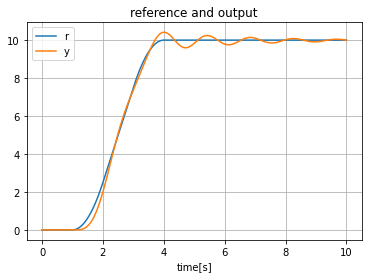

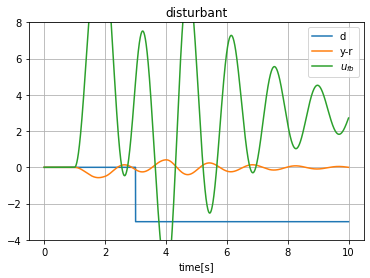

In [6]:
plt.figure()
plt.plot( list_time, list_r, label="r" )
plt.plot( list_time, list_y, label="y" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()
plt.title("reference and output")

plt.figure()
plt.plot( list_time, list_d, label="d" )
plt.plot( list_time, list_y - list_r, label="y-r" )
plt.plot( list_time, list_u_fb, label=r"$u_{fb}$" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()
plt.ylim(-4,8)
plt.title("disturbant")


In [7]:
# 初期化
P = ExecutableSSDigSystem(P_ss_dig,np.matrix([[0],[0]]),0)
K = ExecutableSSDigSystem(K_ss_dig,np.matrix([[0]]),0)

# シミュレーション格納用リスト
list_y = np.empty(0)
list_u_ff = np.empty(0)
list_u_fb = np.empty(0)

# シミュレーション
for (r,dot_r,ddot_r,d) in zip(list_r,list_dot_r,list_ddot_r,list_d):
    
    # FF制御器計算
    u_ff = ddot_r / omega_0 + dot_r
    
    # FB制御器の状態・出力更新
    # 1周期前のPの出力を使っている
    K.execute( r - P.y )
    u_fb = K.y
    
    # 制御対象の状態更新
    P.execute( u_ff + u_fb + d )
    
    # 結果の格納
    list_u_ff = np.append( list_u_ff,u_ff )
    list_u_fb = np.append( list_u_fb,u_fb )
    list_y = np.append( list_y,P.y )


Text(0.5, 1.0, 'disturbant')

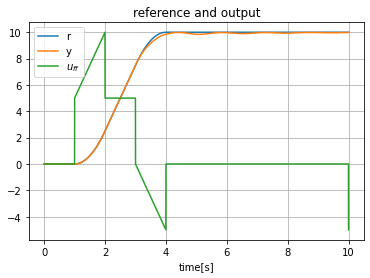

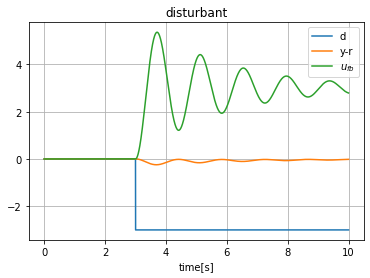

In [8]:
plt.figure()
plt.plot( list_time, list_r, label="r" )
plt.plot( list_time, list_y, label="y" )
plt.plot( list_time, list_u_ff, label=r"$u_{ff}$" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()
plt.title("reference and output")

plt.figure()
plt.plot( list_time, list_d, label="d" )
plt.plot( list_time, list_y - list_r, label="y-r" )
plt.plot( list_time, list_u_fb, label=r"$u_{fb}$" )
plt.xlabel("time[s]")
plt.legend()
plt.grid()
plt.title("disturbant")


FF制御を実施すると外乱$d$が印加される3[s]までの間、偏差($y-r$)が存在しいないことがわかります。
また、3[s]後の応答については、その時点での系の状態が異なることからFF制御の実施有無を表現できているとは言えませんが、おおむね同様の（$y$の定性的な振動周波数や振幅の収束の様子などが大きく異ならない）FB制御の効果が得られています。